# Seoul Bike Sharing Demand Prediction

## 1.0 Problem Statement 

In bike sharing system, sufficient and stable bike supply reduces waiting time and improves user experience. The ever-changing nature of bike sharing demand across the day (rush hours vs off-peak), across the year (summer vs winter) and in different weather conditions (sunny vs snowstorm) creates the need for accurate estimates of hourly bike rental demand. To achieve such a goal, some potential machine learning models can be built to predict the hourly bike rental count taking into consideration different elements such as weather, season and holiday. The hourly bike rental demand estimate from the machine learning model can be used as a baseline for data-driven operation management in bike sharing systems (bike redistribution, scheduling of bike maintenance etc). 

In this project, historical bike sharing demand data (Dec 2017 to Nov 2018) from Seoul is used for model building to study the feasibility of the proposed machine learning-based estimation solution. 
This dataset is obtained from UCI machine learning repository and contains hourly public bike rental count in Seoul bike sharing system with the corresponding Weather data and Holidays information. 
The features include weather infomation (Temperature, Humidity, Windspeed, Visibility, Dewpoint Temperature, Solar Radiation, Rainfall and Snowfall) and date information (Seasons, Holiday, Functional Day).
Since the target variable (Rented Bike Count) is continuous, multivariate regression machine learning models can be implemented to solve the bike sharing demand estimation problem, and the potential machine learning models include Multiple linear regression, Polynomial linear regression, Decision trees, Gradient boosted trees (XGBoost), Random forest trees etc.

Link to dataset: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

## 2.0 Exploratory Data Analysis 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### 2.1 Data Loading and Processing 

In this section, data is loaded into dataframe and processed to extract date information in preparation for EDA.

**Load and Examine the Dataset**

In [2]:
#read the csv file into dataframe
raw_data = pd.read_csv('SeoulBikeData.csv', encoding = 'unicode_escape')
print(raw_data.shape)
raw_data.head()

(8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
#check datatype and missing values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

The above information indicates the dataset does not have any missing value as all 8760 entries are non-null.

In [5]:
#check datatype and missing values
round(raw_data.describe())

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.0,8760.0,8760.0,8760.0,8760.0,8760.0,8760.0,8760.0,8760.0,8760.0
mean,705.0,12.0,13.0,58.0,2.0,1437.0,4.0,1.0,0.0,0.0
std,645.0,7.0,12.0,20.0,1.0,608.0,13.0,1.0,1.0,0.0
min,0.0,0.0,-18.0,0.0,0.0,27.0,-31.0,0.0,0.0,0.0
25%,191.0,6.0,4.0,42.0,1.0,940.0,-5.0,0.0,0.0,0.0
50%,504.0,12.0,14.0,57.0,2.0,1698.0,5.0,0.0,0.0,0.0
75%,1065.0,17.0,22.0,74.0,2.0,2000.0,15.0,1.0,0.0,0.0
max,3556.0,23.0,39.0,98.0,7.0,2000.0,27.0,4.0,35.0,9.0


**Convert to Datetime Format**

In [24]:
# convert the date string in the 'Date' column to datetime format 
raw_data['Date'] = pd.to_datetime(raw_data['Date'], dayfirst=True)

# extract year, month, day from the date column in the original dataframe and append to the raw_data dataframe
raw_data['Year'] = raw_data['Date'].apply(lambda x: x.year)
raw_data['Month'] = raw_data['Date'].apply(lambda x: x.month)
raw_data['Day'] = raw_data['Date'].apply(lambda x: x.dayofweek)

raw_data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,4
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,4
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,4


### 2.2 Stripplot of Bike Sharing Demand Distribution 

The stripplot below shows the distribution of bike sharing demand count based on different time scales (hour, day, month and season). 

Observations:

1. Stripplot of Seoul Bike Sharing Demand Distribution (by hour): The bike sharing demand fluctuates greatly within a day, peaking at 8am during morning rush hours and 6pm during evening rush hours. Beyond that, the bike sharing demand is relatively high in the afternoon and evening (12:00- 23:00) in comparison with bike sharing demand after midnight and in early morning.
2. Stripplot of Seoul Bike Sharing Demand Distribution (by day): Bike sharing demand is higher on weekdays compared to weekends. By observing the degree of dispersion of the datapoints, the variation of bike sharing demand on weekdays is higher as well, indicating the bike sharing demand is more stable during the weekend.
3. Stripplot of Seoul Bike Sharing Demand Distribution (by Month/Seasons): Bike sharing demand is much higher in warmer seasons (spring, summer, fall) compared to winter. Across the year, bike sharing demand peaks in June.

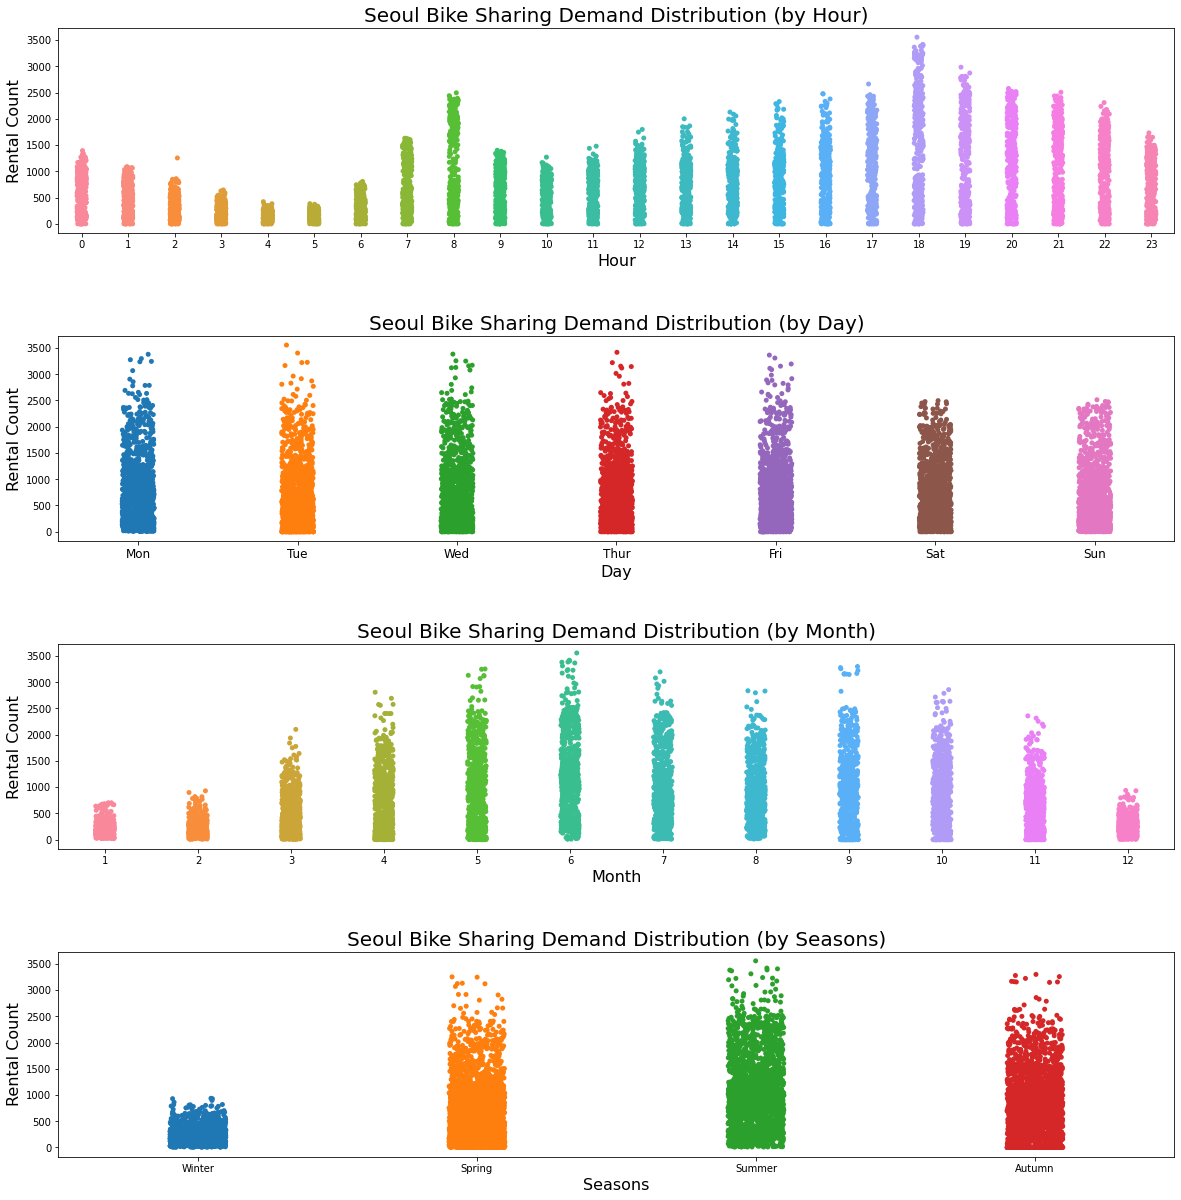

In [25]:
# visualization of bike sharing count by hour, day and month and season 
# using seaborn stripplot

fig, axs = plt.subplots(nrows=4, figsize=(20, 16))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5)

ax_index = 0

#use for loop to plot seaborn stripplot for different features
for time_category in ['Hour', 'Day', 'Month', 'Seasons']: 
  
  sns.stripplot(x=str(time_category), y='Rented Bike Count', data=raw_data, ax=axs[ax_index])
  axs[ax_index].set_title('Seoul Bike Sharing Demand Distribution (by {})'.format(time_category), fontsize=20)
  axs[ax_index].set_xlabel(str(time_category), fontsize=16)
  axs[ax_index].set_ylabel('Rental Count', fontsize=16)

  if ax_index == 1:
    axs[1].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=12)  

  ax_index+= 1

### 2.3 Barplot of Bike Sharing Demand Distribution by Seasons

The barplot below shows the average hourly bike rental count in different seasons. Summer leads with approximately 1000 hourly rental count on average, followed by Fall with approximately 800 units and Spring with 750 units. The average hourly bike sharing demand is around 200 in Winter.

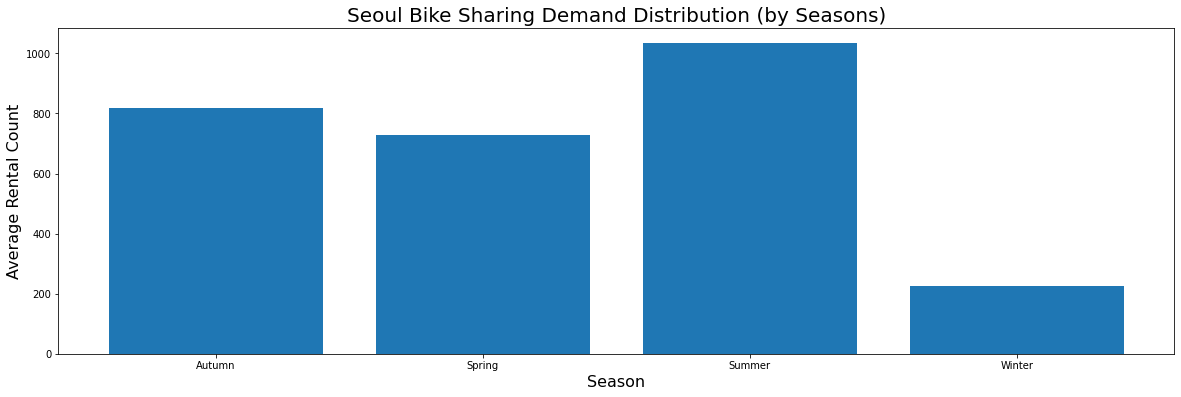

In [26]:
plt.figure(figsize=(20,6))
y = raw_data.groupby("Seasons").mean()['Rented Bike Count']
x = list(y.index)
plt.xlabel("Season",fontsize=16)
plt.ylabel("Average Rental Count", fontsize=16)
plt.title("Seoul Bike Sharing Demand Distribution (by Seasons)", fontsize=20)
plt.bar(x,y)
plt.show()

### 2.4 Heatmap of Bike Sharing Demand Distribution (Day and Hour)



The heatmap plot below shows the distribution of bike sharing demand at different times during a day and how the distribution differs on different days during the week.

Observations:

1. On weekdays, most bike rentals occur during morning rush hours (8am) and evening rush hours (6pm). Bike sharing demand is significantly higher in the afternoon and evening (12:00- 23:00) in comparison with bike sharing demand after midnight and in early morning.
2. Bike rental is extremely popular during Friday rush hours.
3. Compared to weekdays, the distribution of bike sharing demand is relatively even across the day during the weekend with higher demand in the afternoon.

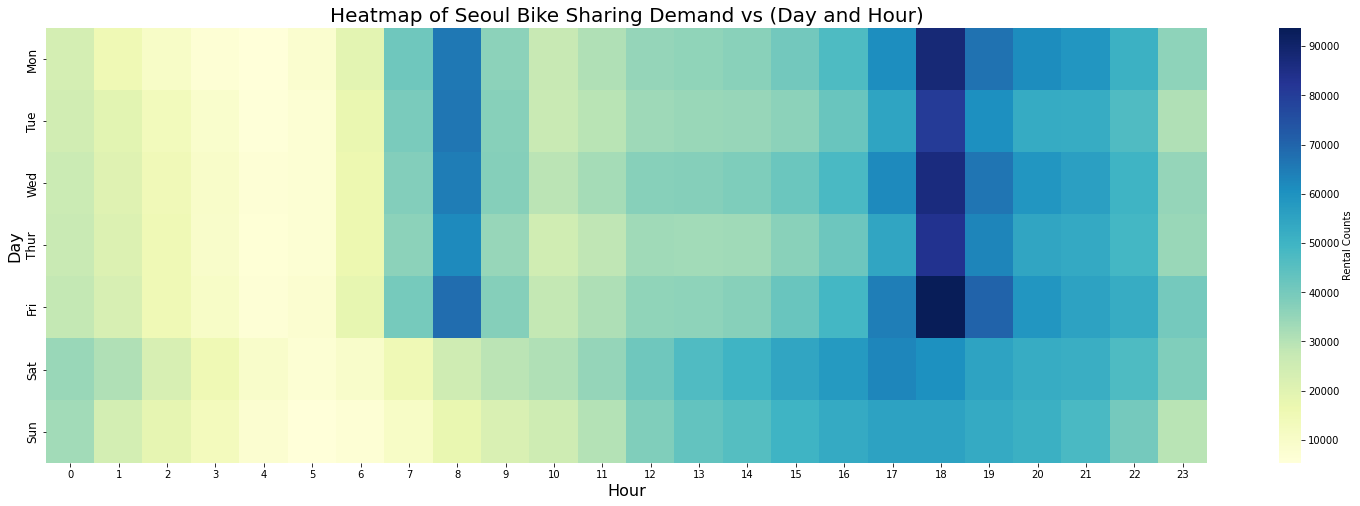

In [27]:
#visualize bike sharing demand by day and hour

#create temporary dataframe containg the independent and dependent variables
tmp_day_hour = raw_data[['Day', 'Hour', 'Rented Bike Count']]

#pivot columns and apply aggregrate function to the bike sharing count
day_hour_pivot = pd.pivot_table(tmp_day_hour, values='Rented Bike Count', index=['Day'], columns = ['Hour'], aggfunc=np.sum)

#plot the heamtmap
plt.figure(figsize=(26, 8))
ax = sns.heatmap(day_hour_pivot,  
                 cbar_kws={'label': 'Rental Counts'}, 
                 cmap="YlGnBu"
                 )

ax.set_title('Heatmap of Seoul Bike Sharing Demand vs (Day and Hour)', fontsize=20)
ax.set_xlabel('Hour', fontsize=16)
ax.set_ylabel('Day', fontsize=16)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=12)
plt.show()

### 2.5 Heatmap of Bike Sharing Demand Distribution (Month and Hour)

The heatmap plot below shows the distribution of bike sharing demand at different times during a day and how the distribution differs in different months.

Observations:

1. In general, most bike rentals occur during morning rush hours (8am) and evening rush hours (6pm) throughout the year. Such pattern is more obvious during the warmer months.
2. Highest bike sharing demand is observed in June during evening rush hours.
3. The distribution of bike sharing demand is relatively even at low level across the day in winter when compared to warmer months.

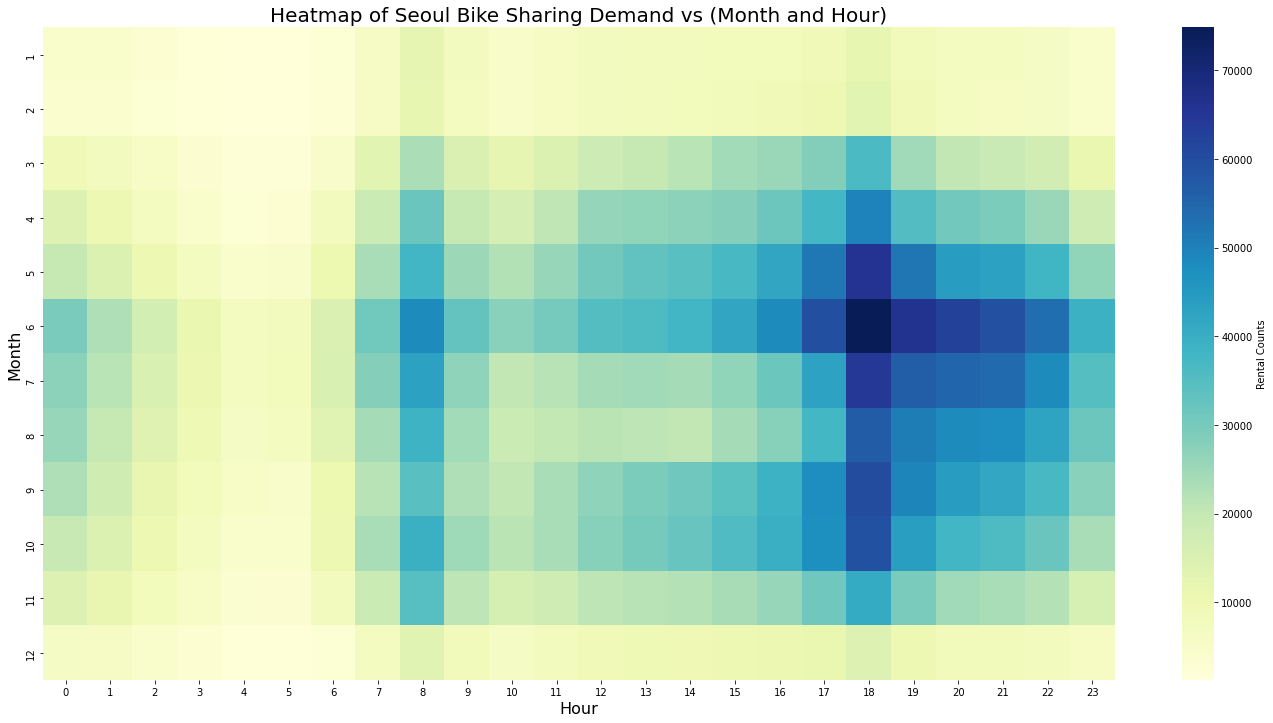

In [28]:
#visualize bike sharing demand by month and hour

#create temporary dataframe containg the independent and dependent variables
tmp_month_hour = raw_data[['Month', 'Hour', 'Rented Bike Count']]

#pivot columns and apply aggregrate function to the bike sharing count
month_hour_pivot = pd.pivot_table(tmp_month_hour, values='Rented Bike Count', index=['Month'], columns = ['Hour'], aggfunc=np.sum)

#plot the heamtmap
plt.figure(figsize=(24, 12))
ax = sns.heatmap(month_hour_pivot,  
                 cbar_kws={'label': 'Rental Counts'}, 
                 cmap="YlGnBu"
                 )

ax.set_title('Heatmap of Seoul Bike Sharing Demand vs (Month and Hour)', fontsize=20)
ax.set_xlabel('Hour', fontsize=16)
ax.set_ylabel('Month', fontsize=16)
plt.show()

### 2.6 Heatmap of Bike Sharing Demand Distribution (Temperature and Humidity)

The heatmap plot below shows the distribution of bike sharing demand in different weather conditions (Temperature and Humidity)

Observations:

1. In general, majority of bike rentals occur in mild weather conditions (Temperature range of 20°C to 33°C and Humidity range of 34% to 68%).
2. The highest bike sharing demand is observed at around 26°C and 45% humidity.

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


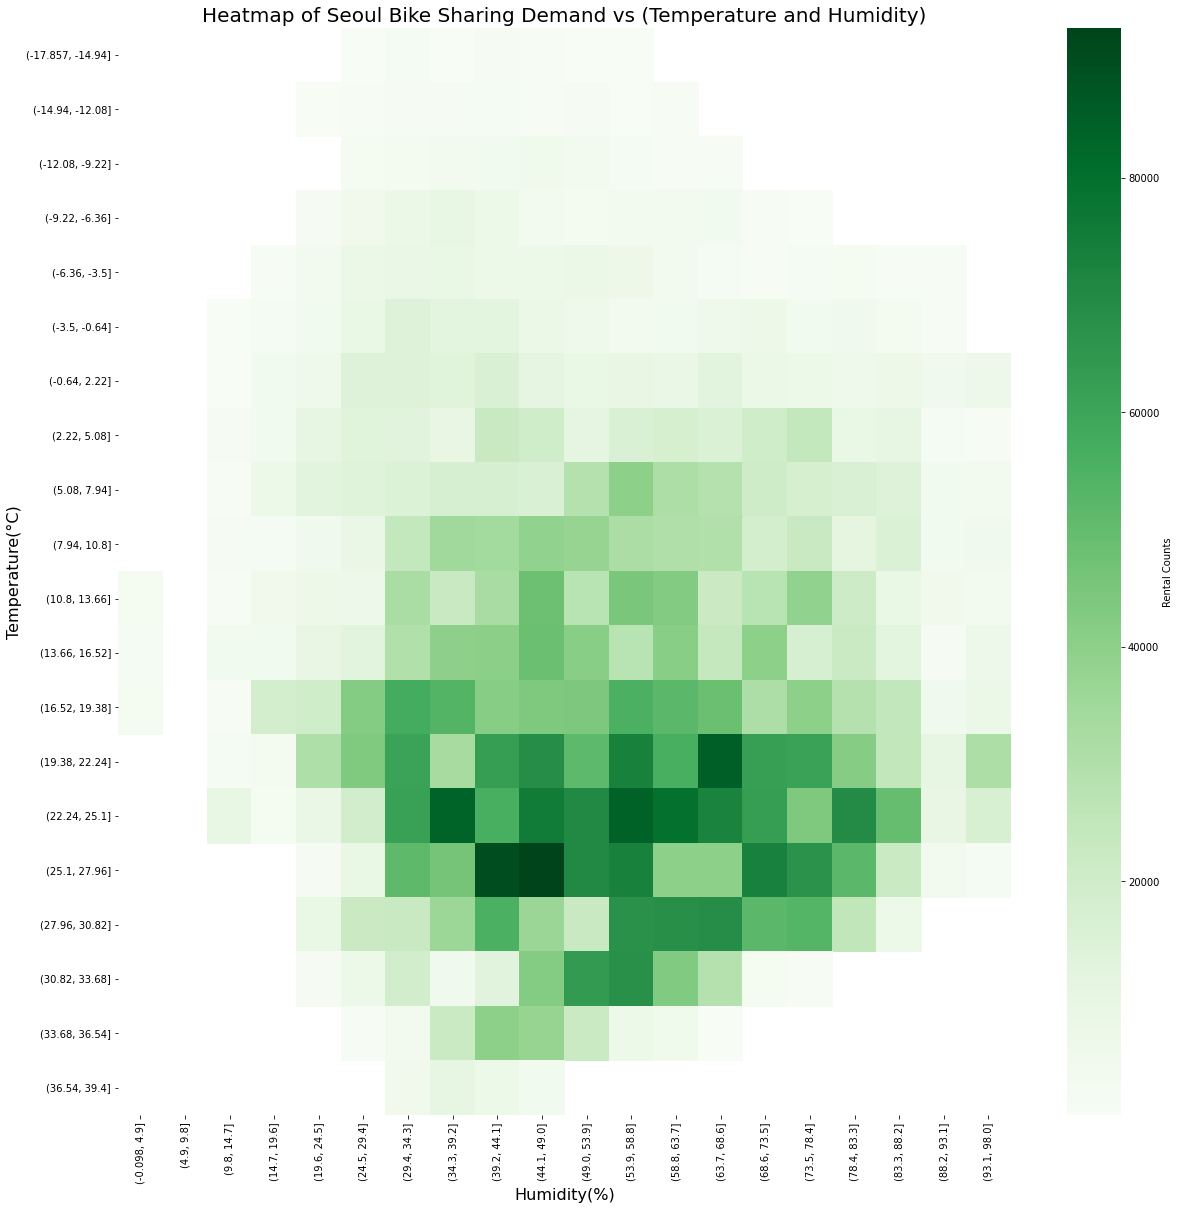

In [29]:
#visualize bike sharing demand by temperature and humidity

#create temporary dataframe containg the independent and dependent variables
tmp_temp_humid = raw_data[['Temperature(°C)', 'Humidity(%)', 'Rented Bike Count']]
#rename the columns of the indepenent variables 
tmp_temp_humid.rename(columns = {'Temperature(°C)':'Temp', 'Humidity(%)':'Humid', 'Rented Bike Count':'Count'}, inplace = True)

#group the bike sharing demand based on temperature and humidity and calculate the sum of bike sharing demand
temp_hum_binned = tmp_temp_humid.groupby([pd.cut(tmp_temp_humid.Temp, 20), pd.cut(tmp_temp_humid.Humid, 20)]).Count.sum().unstack()

#plot the heamtmap
plt.figure(figsize=(20, 20))
ax = sns.heatmap(temp_hum_binned,  
                 cbar_kws={'label': 'Rental Counts'}, 
                 cmap="Greens"
                 )

ax.set_title('Heatmap of Seoul Bike Sharing Demand vs (Temperature and Humidity)', fontsize=20)
ax.set_xlabel('Humidity(%)', fontsize=16)
ax.set_ylabel('Temperature(°C)', fontsize=16)
plt.show()

### 2.7 Heatmap of Bike Sharing Demand Distribution (Temperature and Windspeed)

The heatmap plot below shows the distribution of bike sharing demand in different weather conditions (Temperature and Windspeed)

Observations:

1. In general, majority of bike rentals occur in mild weather conditions (Temperature range of 20°C to 31°C and Windspeed range of 0.74-2.22 m/s).
2. The highest bike sharing demand is observed at around 23°C and windspeed of 1.65 m/s.
3. It is also worth noting that bike sharing demand is very low with windspeed upwards of 3.3 m/s.

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


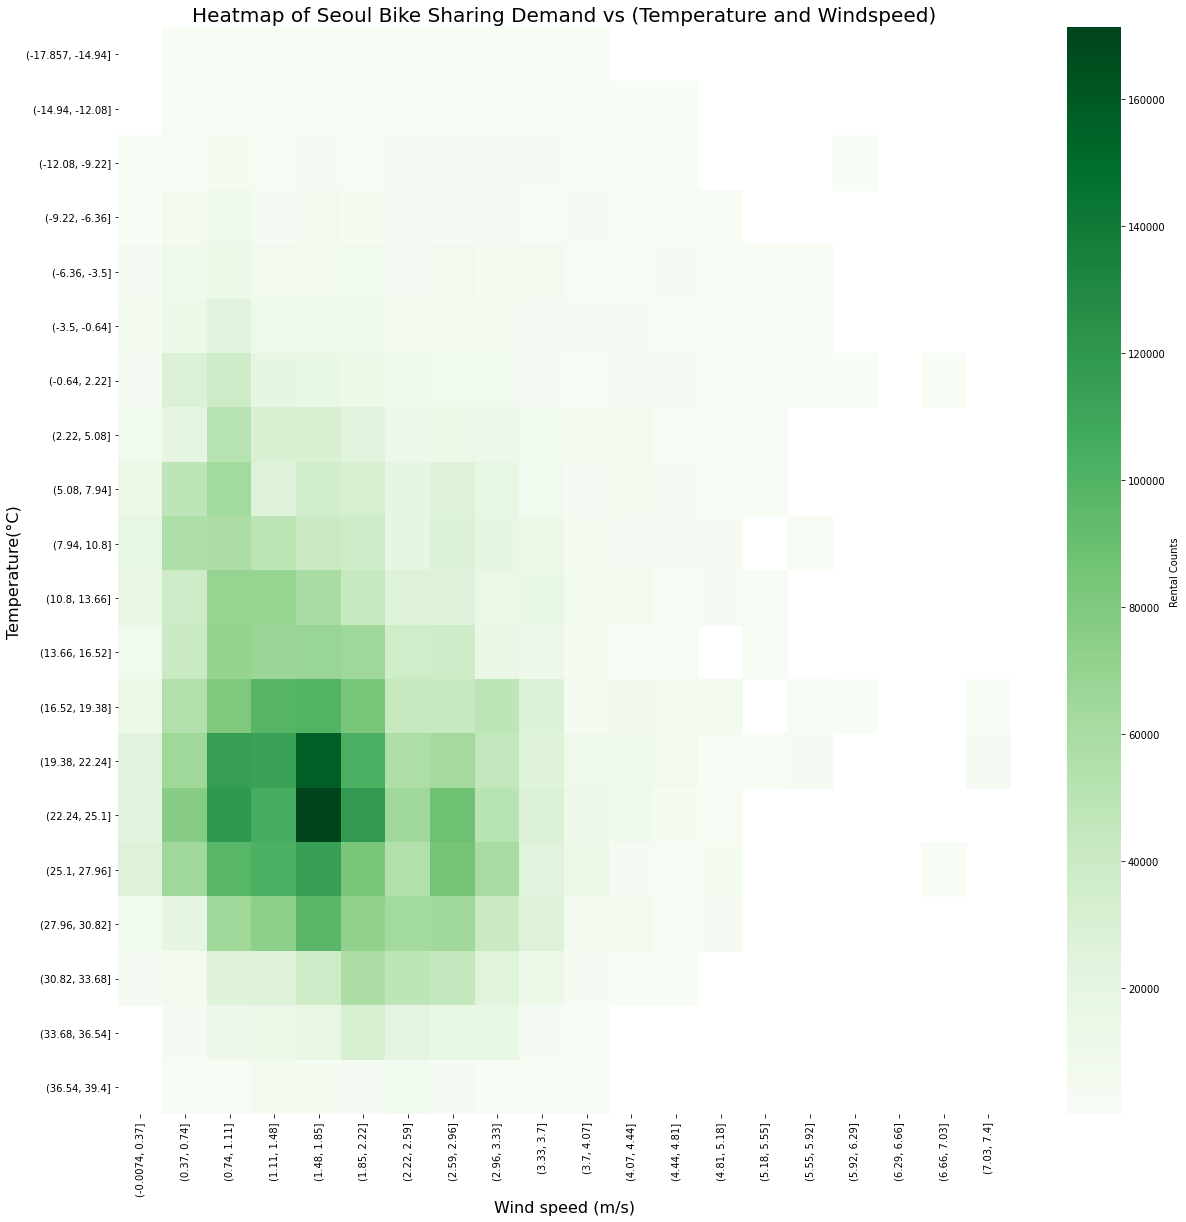

In [30]:
#visualize bike sharing demand by temperature and wind speed

#create temporary dataframe containg the independent and dependent variables
tmp_temp_wind = raw_data[['Temperature(°C)', 'Wind speed (m/s)', 'Rented Bike Count']]
#rename the columns of the indepenent variables
tmp_temp_wind.rename(columns = {'Temperature(°C)':'Solar', 'Wind speed (m/s)':'Rainfall', 'Rented Bike Count':'Count'}, inplace = True)

#group the bike sharing demand based on temperature and windspeed and calculate the sum of bike sharing demand
temp_wind_binned = tmp_temp_wind.groupby([pd.cut(tmp_temp_wind.Solar, 20), pd.cut(tmp_temp_wind.Rainfall, 20)]).Count.sum().unstack() 

#plot the heamtmap
plt.figure(figsize=(20, 20))
ax = sns.heatmap(temp_wind_binned,  
                 cbar_kws={'label': 'Rental Counts'}, 
                 cmap="Greens"
                 )

ax.set_title('Heatmap of Seoul Bike Sharing Demand vs (Temperature and Windspeed)', fontsize=20)
ax.set_xlabel('Wind speed (m/s)', fontsize=16)
ax.set_ylabel('Temperature(°C)', fontsize=16)
plt.show()

## 3.0 Data Preprocessing

In this section, categorical data is converted into encoded numerical value in preparation for implementation of Machine Learning in Section 4.

During examination, it was determined that the dataset has no NA (missing values) nor corrupt/incorrupted data in the dataset thus no data cleaning is required. 

**Examine Categorical Data**

Check the datatype of independent variables in the dataset and identify the categorical data that needs one hot encoding. 

In [31]:
#check the datatype of independent variables in the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [32]:
#filter for categorical features 
cat_feature = raw_data.select_dtypes(include=['object']).columns.values
print(cat_feature)

['Seasons' 'Holiday' 'Functioning Day']


In [33]:
#check categorical data
for feature in cat_feature:
    print(raw_data[feature].unique())

['Winter' 'Spring' 'Summer' 'Autumn']
['No Holiday' 'Holiday']
['Yes' 'No']


**One Hot Encoding for Categorical Data**

Considering seasons, holiday and functional day are all non ordinal categorical data (order does not matter), therefore, one hot encoding is applied to convert categorical data to numerical data so that the categorical data can be processed using regression models.

In [34]:
# Label Encoding features
def feature_label(data, feature):
    unique_val = np.sort(data[feature].unique())
    
    value_to_index = {}
    for i, value in enumerate(unique_val):
        value_to_index[value] = i
    return value_to_index

# Ecoded features
def feature_encoded(data, feature):
    data[feature] = data[feature].map(feature_label(data, feature))
    data[feature] = data[feature].astype(int)

# Encoding for all categorical features
cat_dict = {} # Store catogeries detailed info of each feature before converting to numerical values
for feature in cat_feature:
    cat_dict[feature] = feature_label(raw_data, feature) 
    feature_encoded(raw_data, feature)

print(cat_dict)

{'Seasons': {'Autumn': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}, 'Holiday': {'Holiday': 0, 'No Holiday': 1}, 'Functioning Day': {'No': 0, 'Yes': 1}}


In [35]:
raw_data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,1,1,2017,12,4
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,1,1,2017,12,4
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,1,1,2017,12,4
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,1,1,2017,12,4
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,1,1,2017,12,4


In [36]:
# Encoding the categorical values using dummy variables

col_drop = []
for i,feature in enumerate(cat_feature):
    
    # Create dummy features for each categorical feature
    dummy_feat = pd.get_dummies(raw_data[feature], prefix=feature) 
    
    # Store the new dummy features to a new dataframe
    if i == 0:
        df_temp = dummy_feat
    else:
        df_temp = pd.concat([df_temp, dummy_feat],axis=1) 
    
    # List - to drop original categorical feature columns
    col_drop.append(feature) 
    
    # List - to drop one of each of the dummy variables which value is implied by the other dummy variable columns
    col_drop.append(dummy_feat.columns[-1])

# Add the new dummy features to the original cleaned dataframe via concating
data = pd.concat([raw_data, df_temp],axis=1) 

# Drop the original categorical feature columns and one of each of the dummy variables
data = data.drop(col_drop, axis = 1) 

# Present
print(data.shape)
data.head()

(8760, 19)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Year,Month,Day,Seasons_0,Seasons_1,Seasons_2,Holiday_0,Functioning Day_0
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,2017,12,4,0,0,0,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,2017,12,4,0,0,0,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,2017,12,4,0,0,0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,2017,12,4,0,0,0,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,2017,12,4,0,0,0,0,0


## 4.0 Machine Learning Model Implementation

 In order to estimate the bike sharing demand, multivariate regression machine learning model can be implemented. The potential machine learning models are Multiple linear regression, Polynomial linear regression, Decision trees, Gradient boosted trees (XGBoost), Random Forest trees etc.

The two ensemble learning models - XGBoost regression and Random forest regression models are implemented in this project considering these two advanced decision tree-based machine learning algorithms are flexible and easy to use. Additionally, these two models generally perform well and have hyperparameters that can be tuned to avoid overfitting issues.

### 4.1 Train Test Split 


1. Split the dataset into training and testing set in 7:3 ratio
2. Standardize the features using StandardScaler


In [37]:
# split dataset into training set and testing set
X_data, y_data = data.iloc[:,2:], data.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=100)

# Standardization
scaler = StandardScaler()

# Scaling features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verify shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6132, 17) (6132,)
(2628, 17) (2628,)


### 4.2 Model Implementation and Evaluation

#### 4.2.1 XGBoost Regression

XGBoost is considered superior in terms of accuracy and efficiency when compared to logistic and linear regression. XGBoost offers great adaptability through its ultilization of parallel and disributed computing and proficient meomory usage. XGBoost uses decision trees as base learners and combines many weak learners to make a strong learner. Since XGBoost combines the output of many models in the final prediction, it is usually referred to as an ensemble method. XGBoost is highly flexible, efficient and works well in small to medium dataset thus is considered suitable for our purposes.

Below is the implementation of the XGBoost regression model using KFold method in cross-validation

---- XGBoost ----
Training score: 0.9899
Mean cross-validation score: 0.9380
K-fold CV average score: 0.9359

Performance metrics on testing set
MSE: 28558.64
RMSE: 168.99
coefficient of determination (R square): 0.93


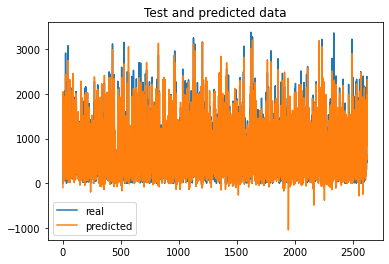

In [38]:
# XGBoost
# create regressor object
xgbr = xgb.XGBRegressor(verbosity=0, random_state=100) 

# fit the regressor with x and y data
xgbr.fit(X_train, y_train)
print("---- XGBoost ----")

# Predicting and checking the results
score = xgbr.score(X_train, y_train)  
print("Training score: %.4f" % score)

# apply the cross-validation method to evaluate the training score
scores = cross_val_score(xgbr, X_train, y_train, cv=10)
print("Mean cross-validation score: %.4f" % scores.mean())

# use the KFlold method in cross-validation
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

# predict test data and check the prediction accuracy using MSE, RMSE and R square as accuracy metrics
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nPerformance metrics on testing set")
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("coefficient of determination (R square): %.2f" % r2_score(y_test, y_pred))

# visualize the original and predicted test data in a plot to compare visually
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="real")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

On one hand, the XGboost regression model yields high training accuracy of 98.99%, mean cross-validation score of 0.938, and k-fold CV average score of 0.9359. On the other hand, in the testing dataset, the model achived very low RMSE value of 168.99 compared to the average target variable value of 705 and high R square of 0.93 (high explained variance score - 93% of the variability observed in the target variable of rented bike count is explained by the regression model). This indicates that the model fits and performs well on both training and testing datasets and the problems of overfitting and underfitting of the trained model has not occurred. In addition, in the plot of prediction vs target, the predicted rental count and actual rental count matches up fairly well, demonstrating excellent model performance.

### 4.2.2 Random Forest Regression

Random Forest builds a 'forest' that ensembles decision trees and usually these decision treess are trained with the 'bagging method'. The advantage of the bagging method is that it involves a combination of learning models that increases the overall result. While growing the trees, random forest adds additional randomness to the model. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. Thus random forest reduces overfitting in decision trees and offers great accuracy. Additionally, random forest also works well with both categorical and continuous values. The random forest technique can also handle big data with numerous variables running into thousands. It can automatically balance data sets when a class is more infrequent than other classes in the data. The method also handles variables fast, making it suitable for complicated tasks. Thus random forest is implemented in our project.

Below is the implementation of the Random Forest regression model using KFold method in cross-validation

---- Random Forest ----
Training score: 0.9904
Mean cross-validation score: 0.9291
K-fold CV average score: 0.9279

Performance metrics on testing set
MSE: 31912.18
RMSE: 178.64
coefficient of determination (R square): 0.93


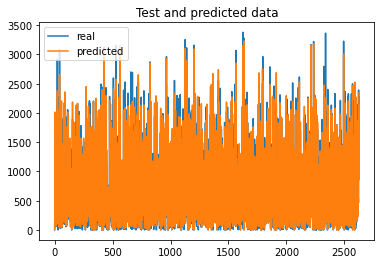

In [39]:
# Random Forest
# create regressor object
rf = RandomForestRegressor(random_state=100)

# fit the regressor with x and y data
rf.fit(X_train, y_train)
print("---- Random Forest ----")

# Predicting and checking the results
score = rf.score(X_train, y_train)  
print("Training score: %.4f" % score)

# apply the cross-validation method to evaluate the training score
scores = cross_val_score(rf, X_train, y_train, cv=10)
print("Mean cross-validation score: %.4f" % scores.mean())

# use the KFlold method in cross-validation
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(rf, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_cv_scores.mean())

# predict test data and check the prediction accuracy using MSE, RMSE and R square as accuracy metrics
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nPerformance metrics on testing set")
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("coefficient of determination (R square): %.2f" % r2_score(y_test, y_pred))

# visualize the original and predicted test data in a plot to compare visually
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="real")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

On one hand, the Random Forest regression model yields high training accuracy up to 99.04%, mean cross-validation score of 0.929 and k-fold CV average score of 0.9279. On the other hand, in the testing dataset, the model achieved very low RMSE value compared to the average target variable value of 705 and high R square of 0.93 (high explained variance score - 93% of the variability observed in the target variable of rented bike count is explained by the regression model), which demonstrates the high capability of the established random forest model in accurately predicting the bike sharing demand. The testing and predicted data also matches up very well in the plot, which speaks to the model's great accuracy. 

However, XGBoost model performs better on the testing dataset as is indicated by its lower RMSE value, in comparison with the random forest model.

## 5.0 Hyperparameter Tunning 

In this section, the hyperparameters of the two ML models are fine-tuned using Gridsearch to optimize model performance.

### 5.1 Hyperparameter tunning for XGBoost Regression using Gridsearch

Below is the implementation of hyperparameter tunning on XGBoost regression model using gridsearch. The two parameters being tunned are learning rate and max depth, which are two of the key hyperparameters that have significant impact on the characteristics and performance of the XGBoost model. Appropriate learning rate warrants gradual and stable model convergence while max depth determines the complexity of the model for sufficient feature representiveness.

Hyperparameter tunning for XGBoost Regression using Gridsearch

XGBRegressor best score:  0.9462327342708651
XGBRegressor best parameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

Performance metrics on testing set
MSE: 24357.29
RMSE: 156.07
coefficient of determination (R square): 0.94


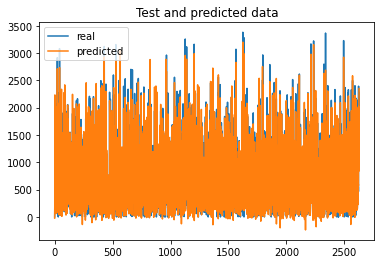

In [40]:
# Hyperparameter tunning using gridsearch
# XGBRegressor 

# create regressor object
xgbr_gs = xgb.XGBRegressor(verbosity=0, random_state=100)

# define hyperparameters 
parameters_xgbr = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['reg:linear'],
                  'learning_rate': [.03, 0.05, .07], #so called `eta` value
                  'max_depth': [5, 6, 7],
                  'min_child_weight': [4],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [500]
                   }

# define the gridsearch
xgb_grid = GridSearchCV(xgbr_gs,
                        parameters_xgbr,
                        cv = 10,
                        n_jobs = -1 #The number of jobs to run in parallel for both fit and predict
                        )

#fit training data
xgb_grid.fit(X_train, y_train)

#print the results 
print("Hyperparameter tunning for XGBoost Regression using Gridsearch\n")
print("XGBRegressor best score: ", xgb_grid.best_score_)
print("XGBRegressor best parameters: ", xgb_grid.best_params_)

# predict test data and check the prediction accuracy using MSE, RMSE and R square as accuracy metrics
y_pred = xgb_grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nPerformance metrics on testing set")
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("coefficient of determination (R square): %.2f" % r2_score(y_test, y_pred))

# visualize the original and predicted test data in a plot to compare visually
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="real")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

From gridsearch, the performance of the XGBoost model has been improved, with learning rate of 0.05 and max_depth of 7 yields best model performance: RMSE of 156.07 and R square valUe of 0.94 compared to 168.99 and 0.93 achieved with the baseline model. As can be seen in the plot of predicted and actual bike sharing demand count, the discrepency between predicted value and actual value is smaller, especially at the spikes and low points on the plot

### 5.2 Hyperparameter tunning for Random Forest Regression using Gridsearch

Below is the implementation of hyperparameter tunning on XGBoost regression model using gridsearch. The five hyperparameters tunned in gridsearch are n_estimators, max_features, min_sample_split, max_depth and bootstrap. n_estimators is the number of trees in the forest, max_features is the number of features to consider when looking for the best split, min_sample_split is the minimum of samples required to split an internal node, max_depth is the maximum depth of the tree while bootstrap is whether bootstrap samples are used when building trees. The combination of these five hyperparameters determines the complexity of the model and strategies for building the decision tree and random forest, which ultimately determines the performance of the model.

Hyperparameter tunning for Random Forest Regression using Gridsearch

RandomForestRegressor best score:  0.9291247268352976
RandomForestRegressor best parameters:  {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}

Performance metrics on testing set
MSE: 31912.18
RMSE: 178.64
coefficient of determination (R square): 0.93


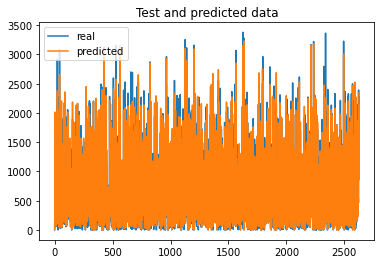

In [41]:
# Hyperparameter tunning using gridsearch
# RandomForestRegressor 

# create regressor object
rf_gs = RandomForestRegressor(random_state=100)

# define hyperparameters 
parameters_rf = {"n_estimators"      : [10, 50, 100, 200],
                 "max_features"      : ["auto", "sqrt", "log2"],
                 "min_samples_split" : [2, 5, 8],
                 "max_depth"         : [5, 50, None],
                 "bootstrap"         : [True, False],
                 #"criterion"         :['squared_error', 'absolute_error']
                 }

# define the gridsearch
rf_grid = GridSearchCV(rf_gs, 
                    parameters_rf, 
                    cv=10,
                    n_jobs=-1 #The number of jobs to run in parallel for both fit and predict
                    )

#fit training data
rf_grid.fit(X_train, y_train)

#print the results 
print("Hyperparameter tunning for Random Forest Regression using Gridsearch\n")
print("RandomForestRegressor best score: ", rf_grid.best_score_)
print("RandomForestRegressor best parameters: ", rf_grid.best_params_)

# predict test data and check the prediction accuracy using MSE, RMSE and R square as accuracy metrics
y_pred = rf_grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nPerformance metrics on testing set")
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("coefficient of determination (R square): %.2f" % r2_score(y_test, y_pred))

# visualize the original and predicted test data in a plot to compare visually
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="real")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

Different combinations of hyperparameters were tested during model tunning and the resulting model performance are all similar to the baseline model. It is possible that the default parameteres setting of Random Forest regression model yields best accuracy with this dataset, therefore, very few improvement is seen during fine tunning. The best performing model from gridsearch has the following hyperparameters: bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, which yield impressive R square value of 0.93.

## 6.0 Conclusion

To sum up, the XGBoost regression model with fine tuning performs the best on both training and testing dataset and is considered to be the best model to be used for predicting future Seoul bike sharing demand. For tuture work, the proposed model can be further evaluated on out of sample data and continuously improved by retraining the model with larger dataset corporating new data entries.